@author: Gautam Devadiga | gdevadig

# Stock price prediction without Sentiment Analysis

##### Import Libraries and Set Up Variables

In [1059]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


traindata = 'GME_train.csv'
testdata = 'GME_test.csv'

#number of input features used for training
dataNum = 5

#A timestep of 20 is chosen because it roughly corresponds to a month of trading days (excluding weekends and holidays),
#which is a common practice in the stock market to capture monthly trends or cycles.
#Combinations used: 5,10,20,30
timesteps = 5
#Number of training epochs
epochNum = 100

##### Load and Prepare Training Data

In [1060]:
# Loading the training data from a CSV file
dataset_train = pd.read_csv(traindata)
# Selecting the specified columns for training : Here I am considering Open, High, Low, Close and Volume

#LSTMs inherently treat the input data as a sequence where the order of data points is
#important, not the specific timestamps. The data is already in the correct time order, 
#hence the date field is not included in traing the model.

training_set = dataset_train.iloc[:,1:dataNum+1].values


# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


X_train = []
Y_train = []
# Looping over the inputs to prepare the test data
for i in range(timesteps, len(training_set_scaled)):
    # creates list of lists , where each inner list contains a sequence of 20 timesteps of the features 
    X_train.append(training_set_scaled[i-timesteps:i, 0:dataNum])  
    #We are predicting closing price which is at index 3 of training_set_scaled
    #simple list (1D array), where each element corresponds to the actual 
    #Close price that immediately follows each sequence of 20 timesteps
    Y_train.append(training_set_scaled[i, 3])   
# Converting the list into a numpy array
X_train, Y_train = np.array(X_train), np.array(Y_train)
#Reshapes X_train to the format expected by the LSTM layer: [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], dataNum))

##### Build and Train LSTM Model

In [1061]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initialize the Sequential model, which is a linear stack of layers
regressor = Sequential()
#Add the first LSTM layer
#units specifies the number of neurons in the layer
#input_shape specifies the shape of the input (timesteps and features)
regressor.add(LSTM(units = 32, input_shape = (X_train.shape[1], dataNum), return_sequences = True))
regressor.add(LSTM(units = 16))
regressor.add(Dense(units = 1))

#This time return_sequences is not specified since we do not need to return sequences for further layers
#combinations used for optimizer: adam,rmsprop
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
regressor.summary()

#Add the output layer
#Since we are predicting a single value (close price), the Dense layer has one neuron
regressor.fit(X_train, Y_train, batch_size = 32, epochs = epochNum)

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 5, 32)             4864      
                                                                 
 lstm_120 (LSTM)             (None, 16)                3136      
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8017 (31.32 KB)
Trainable params: 8017 (31.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 3s 4ms/step - loss: 0.1467
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0739
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 4/100
4/4 [==============================] 

##### Prepare Test Data and Make Predictions

In [1062]:
#test data has data from(June 1st - i) to August 30. i being equal to timesteps(5,10,20,30).
#i.e if timestep = 5, test data has data from 5/24/2021(5 dates available before 06/01/2021) - 08/30/2021
test_set = pd.read_csv(testdata)
real_stock_price = test_set.iloc[:,1:dataNum+1].values
lenOfReal = len(real_stock_price)
inputs = real_stock_price
# Scale the features
inputs = sc.transform(inputs)

inputs_test = []
# Loop over the test data to create sequences of timesteps length
for i in range(timesteps, len(inputs)):
  inputs_test.append(inputs[i-timesteps:i, 0:dataNum])
inputs_test = np.array(inputs_test)
# Reshape the data into the 3D shape required by LSTMs: [samples, timesteps, features]
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], dataNum))
# Predict the stock price using the trained LSTM model
predicted_stock_price = regressor.predict(inputs_test)

#padding so that predicted_stock_price array has the same number of columns as the input data when scaling 
predicted_stock_price = np.pad(predicted_stock_price,((0,0),(0,dataNum-1)),'constant') 
# Inverse transform the predicted scaled data back to the original stock price range
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#remove the padded columns from the predicted_stock_price array, leaving only the first column, 
#which contains the actual predictions for the closing stock price
predicted_stock_price = np.delete(predicted_stock_price, [1, 2, 3, 4], axis=1)

2/2 [==============================] - 1s 0s/step


##### Plot Test Results

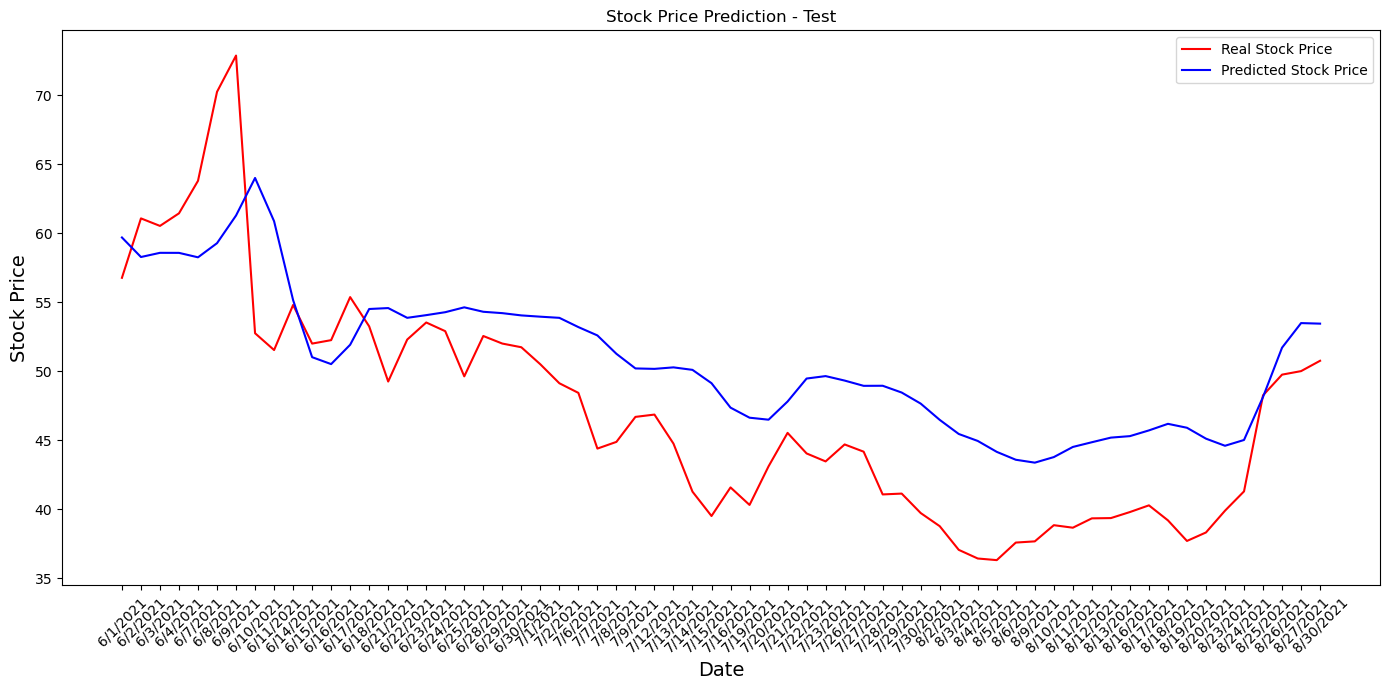

<Figure size 640x480 with 0 Axes>

In [1063]:
#get the dates for plotting
test_date = test_set['Date']
#real close price
real_stock_price = test_set.iloc[timesteps:lenOfReal+1,3:4].values 
# Setting the plot size for better readability
plt.figure(figsize=(14, 7))
#date is offset by timestep since we are predicting from the 21st day(since timestep is 20)
plt.plot(test_date[timesteps:],real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_date[timesteps:],predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction - Test')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
# Rotating date labels for better visibility
plt.xticks(rotation=45)
# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Ensure all labels and titles fit within the figure bounds
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('pic1.png')

##### Plot Training Results

4/4 [==============================] - 1s 5ms/step


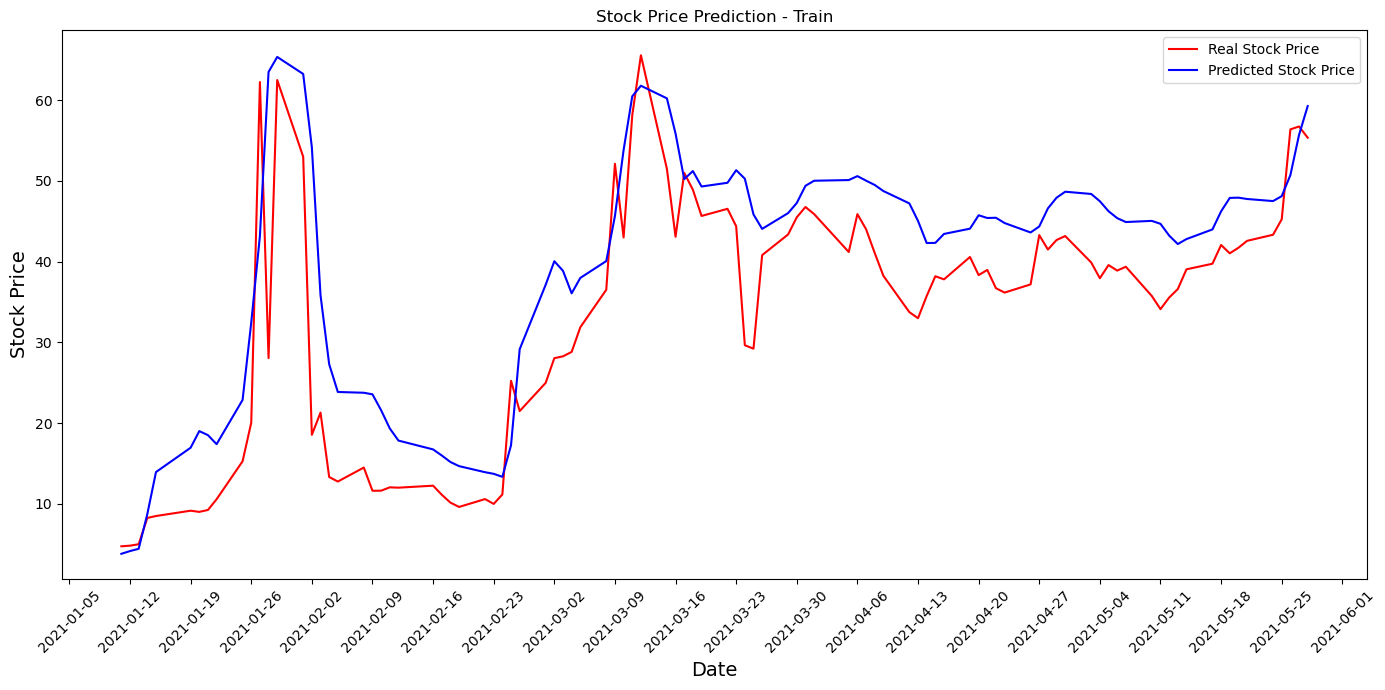

In [1064]:
real_stock_price_train = pd.read_csv(traindata)
#real close price
real_stock_price_train = real_stock_price_train.iloc[timesteps:len(real_stock_price_train)+1,3:4].values


predicted_stock_price_train = regressor.predict(X_train)
#padding so that predicted_stock_price_train array has the same number of columns as the input data when scaling 
predicted_stock_price_train = np.pad(predicted_stock_price_train,((0,0),(0,dataNum-1)),'constant')
predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)
#remove the padded columns from the predicted_stock_price_train array, leaving only the first column, 
#which contains the actual predictions for the closing stock price
predicted_stock_price_train = np.delete(predicted_stock_price_train, [1, 2, 3, 4], axis=1)

#geting date from the input data
train_date = pd.to_datetime(dataset_train['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))
#date is offset by timestep since we are predicting from the 21st day(since timestep is 20)
plt.plot(train_date[timesteps:],real_stock_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(train_date[timesteps:],predicted_stock_price_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction - Train')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
# Rotating date labels for better visibility
plt.xticks(rotation=45)
# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Get the current axis
ax = plt.gca()  
# Set the locator to WeekdayLocator for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  
# Set the formatter to show the year, month, and day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

# Ensure all labels and titles fit within the figure bounds
plt.tight_layout()

# Display the plot
plt.show()

##### Evaluate Model Performance

In [1065]:
import math
from sklearn.metrics import mean_squared_error

rmseTest = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("RMSE_test = " + str(rmseTest))
rmseTrain = math.sqrt(mean_squared_error(real_stock_price_train, predicted_stock_price_train))
print("RMSE_train = " + str(rmseTrain))

RMSE_test = 5.761245032234325
RMSE_train = 9.309054208425962


# Stock price prediction using Sentiment Analysis

##### Preprocess sentiment analysis data for model fusion

In [1066]:
sa_data = pd.read_csv('GME_Sentiment_Analysis.csv', low_memory=False)

In [1067]:
dataset_train = pd.read_csv(traindata)
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/4/2021,4.750000,4.775000,4.287500,4.312500,40090000
1,1/5/2021,4.337500,4.520000,4.307500,4.342500,19846000
2,1/6/2021,4.335000,4.745000,4.332500,4.590000,24224800
3,1/7/2021,4.617500,4.862500,4.505000,4.520000,24517200
4,1/8/2021,4.545000,4.575000,4.270000,4.422500,25928000
...,...,...,...,...,...,...
97,5/24/2021,43.962502,47.115002,43.337502,45.002499,18657200
98,5/25/2021,45.250000,54.277500,45.250000,52.357498,59550000
99,5/26/2021,57.250000,62.119999,56.387501,60.639999,84479600
100,5/27/2021,57.450001,66.000000,56.750000,63.532501,62105200


In [1068]:
#making date field format for both the datasets similar for joining
sa_data['date'] = pd.to_datetime(sa_data['date']).dt.strftime('%m/%d/%Y')

In [1069]:
sa_data.head(5)

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,01/04/2021,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,01/04/2021,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,01/05/2021,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,01/05/2021,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,01/06/2021,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [1070]:
sa_data_new = sa_data[['date','neg','neu','pos']]

In [1071]:
sa_data_new.rename(columns={'date': 'Date'}, inplace=True)

C:\Users\gauta\AppData\Local\Temp\ipykernel_3916\4293873801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_data_new.rename(columns={'date': 'Date'}, inplace=True)


In [1072]:
sa_data_new

,Date,neg,neu,pos
0,01/04/2021,0.000,0.189,0.811
1,01/04/2021,0.000,0.079,0.921
2,01/05/2021,0.000,0.744,0.256
3,01/05/2021,0.115,0.885,0.000
4,01/06/2021,0.000,1.000,0.000
...,...,...,...,...
1033231,12/31/2021,0.128,0.872,0.000
1033232,12/31/2021,0.783,0.217,0.000
1033233,12/31/2021,0.190,0.810,0.000
1033234,12/31/2021,0.000,1.000,0.000


In [1073]:
#since there are multiple sentiments for a single day the rows are grouped with date and the sentiments are averaged
sa_data_grouped = sa_data_new.groupby('Date', as_index=False).mean()

In [1074]:
sa_data_grouped

,Date,neg,neu,pos
0,01/04/2021,0.000000,0.134000,0.866000
1,01/05/2021,0.057500,0.814500,0.128000
2,01/06/2021,0.053500,0.758000,0.188500
3,01/10/2021,0.000000,0.392000,0.608000
4,01/11/2021,0.000000,0.855750,0.144250
...,...,...,...,...
338,12/27/2021,0.045379,0.829341,0.125295
339,12/28/2021,0.035344,0.839699,0.124962
340,12/29/2021,0.042465,0.840487,0.117032
341,12/30/2021,0.040272,0.829572,0.130167


In [1075]:
#changing date format to align with the date format of sentiments data
dataset_train['Date'] = pd.to_datetime(dataset_train['Date']).dt.strftime('%m/%d/%Y')

In [1076]:
dataset_train

,Date,Open,High,Low,Close,Volume
0,01/04/2021,4.750000,4.775000,4.287500,4.312500,40090000
1,01/05/2021,4.337500,4.520000,4.307500,4.342500,19846000
2,01/06/2021,4.335000,4.745000,4.332500,4.590000,24224800
3,01/07/2021,4.617500,4.862500,4.505000,4.520000,24517200
4,01/08/2021,4.545000,4.575000,4.270000,4.422500,25928000
...,...,...,...,...,...,...
97,05/24/2021,43.962502,47.115002,43.337502,45.002499,18657200
98,05/25/2021,45.250000,54.277500,45.250000,52.357498,59550000
99,05/26/2021,57.250000,62.119999,56.387501,60.639999,84479600
100,05/27/2021,57.450001,66.000000,56.750000,63.532501,62105200


In [1077]:
#both the datasets are merged by matching the date field , it also includes data that was found in stock data which 
#did not match with sentiments data through date field
train_sa = pd.merge(dataset_train,sa_data_grouped, on='Date', how='left')

In [1078]:
train_sa

,Date,Open,High,Low,Close,Volume,neg,neu,pos
0,01/04/2021,4.750000,4.775000,4.287500,4.312500,40090000,0.000000,0.134000,0.866000
1,01/05/2021,4.337500,4.520000,4.307500,4.342500,19846000,0.057500,0.814500,0.128000
2,01/06/2021,4.335000,4.745000,4.332500,4.590000,24224800,0.053500,0.758000,0.188500
3,01/07/2021,4.617500,4.862500,4.505000,4.520000,24517200,NaN,NaN,NaN
4,01/08/2021,4.545000,4.575000,4.270000,4.422500,25928000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
97,05/24/2021,43.962502,47.115002,43.337502,45.002499,18657200,0.063509,0.808719,0.127790
98,05/25/2021,45.250000,54.277500,45.250000,52.357498,59550000,0.052436,0.795781,0.151772
99,05/26/2021,57.250000,62.119999,56.387501,60.639999,84479600,0.058744,0.788218,0.153039
100,05/27/2021,57.450001,66.000000,56.750000,63.532501,62105200,0.058592,0.817233,0.124179


In [1079]:
#There are few null values for sentiment scores which means for some dates in our stock data sentiments
#are not avaialble
train_sa.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
neg       12
neu       12
pos       12
dtype: int64

In [1080]:
#Since it is a time-series data it might be more appropriate to impute missing values based on nearby points in time.
#Here, I have used Linear interpolation which is a method of estimating unknown values that fall between 
#two known values(before and after)
train_sa['neg'] = train_sa['neg'].interpolate(method='linear')
train_sa['neu'] = train_sa['neu'].interpolate(method='linear')
train_sa['pos'] = train_sa['pos'].interpolate(method='linear')

In [1081]:
train_sa

,Date,Open,High,Low,Close,Volume,neg,neu,pos
0,01/04/2021,4.750000,4.775000,4.287500,4.312500,40090000,0.000000,0.134000,0.866000
1,01/05/2021,4.337500,4.520000,4.307500,4.342500,19846000,0.057500,0.814500,0.128000
2,01/06/2021,4.335000,4.745000,4.332500,4.590000,24224800,0.053500,0.758000,0.188500
3,01/07/2021,4.617500,4.862500,4.505000,4.520000,24517200,0.035667,0.790583,0.173750
4,01/08/2021,4.545000,4.575000,4.270000,4.422500,25928000,0.017833,0.823167,0.159000
...,...,...,...,...,...,...,...,...,...
97,05/24/2021,43.962502,47.115002,43.337502,45.002499,18657200,0.063509,0.808719,0.127790
98,05/25/2021,45.250000,54.277500,45.250000,52.357498,59550000,0.052436,0.795781,0.151772
99,05/26/2021,57.250000,62.119999,56.387501,60.639999,84479600,0.058744,0.788218,0.153039
100,05/27/2021,57.450001,66.000000,56.750000,63.532501,62105200,0.058592,0.817233,0.124179


In [1082]:
#test data has data from(June 1st - i) to August 30. i being equal to timesteps(5,10,20,30).
#i.e if timestep = 5, test data has data from 5/24/2021(5 dates available before 06/01/2021) - 08/30/2021

#similar steps are perfromed for test data
test_set = pd.read_csv(testdata)

In [1083]:
test_set['Date'] = pd.to_datetime(test_set['Date']).dt.strftime('%m/%d/%Y')

In [1084]:
test_set.head(10)

,Date,Open,High,Low,Close,Volume
0,05/24/2021,43.962502,47.115002,43.337502,45.002499,18657200
1,05/25/2021,45.250000,54.277500,45.250000,52.357498,59550000
2,05/26/2021,57.250000,62.119999,56.387501,60.639999,84479600
3,05/27/2021,57.450001,66.000000,56.750000,63.532501,62105200
4,05/28/2021,65.742500,67.199997,55.357498,55.500000,47005600
5,06/01/2021,58.369999,63.744999,56.767502,62.255001,38502400
6,06/02/2021,62.220001,73.500000,61.075001,70.559998,64076800
7,06/03/2021,66.427498,68.607498,60.529999,64.544998,32000000
8,06/04/2021,64.004997,66.250000,61.442501,62.090000,14550000
9,06/07/2021,64.500000,70.500000,63.799999,70.002502,24206000


In [1085]:
test_sa = pd.merge(test_set,sa_data_grouped, on='Date', how='left')

In [1086]:
test_sa

,Date,Open,High,Low,Close,Volume,neg,neu,pos
0,05/24/2021,43.962502,47.115002,43.337502,45.002499,18657200,0.063509,0.808719,0.127790
1,05/25/2021,45.250000,54.277500,45.250000,52.357498,59550000,0.052436,0.795781,0.151772
2,05/26/2021,57.250000,62.119999,56.387501,60.639999,84479600,0.058744,0.788218,0.153039
3,05/27/2021,57.450001,66.000000,56.750000,63.532501,62105200,0.058592,0.817233,0.124179
4,05/28/2021,65.742500,67.199997,55.357498,55.500000,47005600,0.051222,0.792775,0.155993
...,...,...,...,...,...,...,...,...,...
64,08/24/2021,41.572498,56.250000,41.287498,52.572498,58608800,0.050305,0.807897,0.141796
65,08/25/2021,51.662498,56.750000,48.250000,49.912498,51444400,0.054910,0.814306,0.130790
66,08/26/2021,50.169998,54.250000,49.750000,51.305000,24954400,0.076433,0.800787,0.122797
67,08/27/2021,51.924999,53.250000,50.005001,51.237499,12923200,0.062746,0.803986,0.133268


In [1087]:
test_sa.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
neg       0
neu       0
pos       0
dtype: int64

##### Visulaize Sentiments trend

In [1088]:
#since there are multiple sentiments for a single day the rows are grouped with date and the sentiments 
#are averaged
sa_data_grouped_vis = sa_data.groupby('date', as_index=False).mean()
sa_data_grouped_vis['date'] = pd.to_datetime(sa_data_grouped_vis['date'])
mask = (sa_data_grouped_vis['date'] >= '2021-01-01') & (sa_data_grouped_vis['date'] <= '2021-08-31')
filtered_data = sa_data_grouped_vis.loc[mask]
#filtered_data['date']=pd.to_datetime(filtered_data['date'])

C:\Users\gauta\AppData\Local\Temp\ipykernel_3916\153635784.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sa_data_grouped_vis = sa_data.groupby('date', as_index=False).mean()


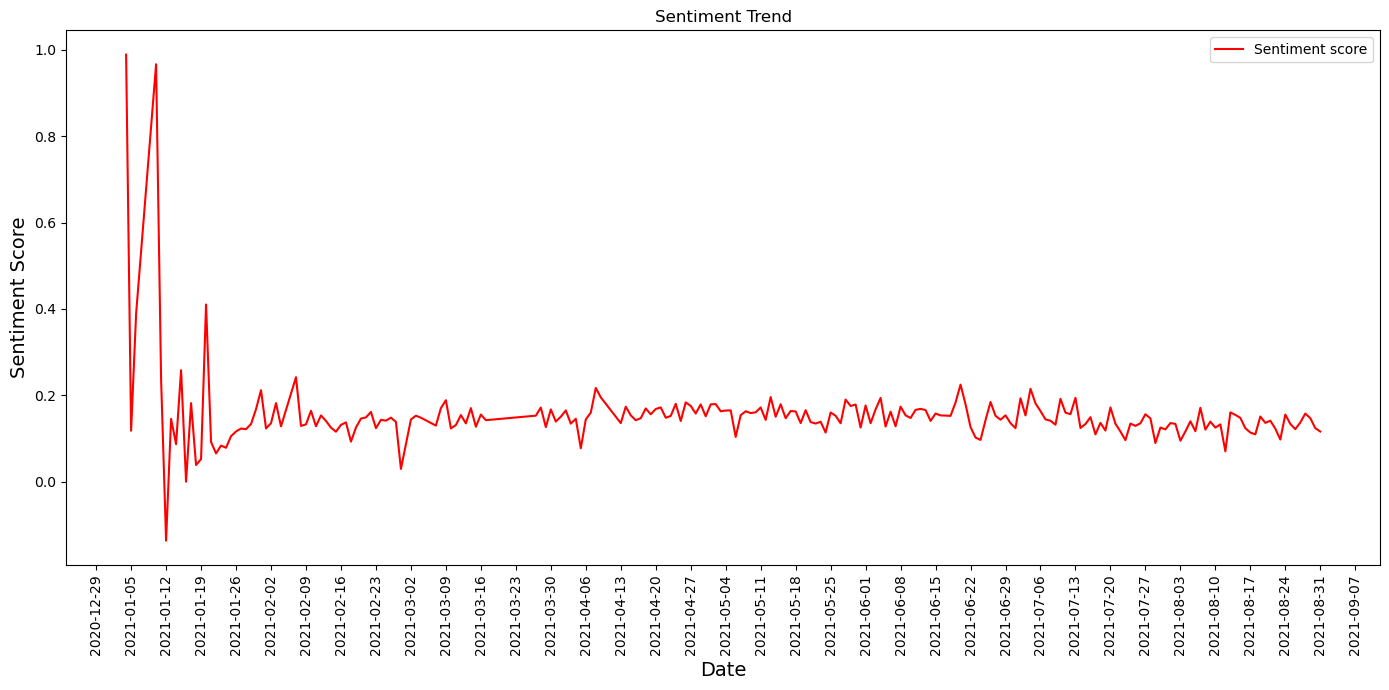

In [1089]:
plt.figure(figsize=(14, 7))
plt.plot(filtered_data['date'],filtered_data['compound'], color = 'red', label = 'Sentiment score')
plt.title('Sentiment Trend')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
# Rotating date labels for better visibility
plt.xticks(rotation=90)
# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Get the current axis
ax = plt.gca()  
# Set the locator to WeekdayLocator for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  
# Set the formatter to show the year, month, and day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

# Ensure all labels and titles fit within the figure bounds
plt.tight_layout()

# Display the plot
plt.show()

##### Import Libraries and Set Up Variables

In [1090]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#number of input features used for training; 3 more for sentiments
dataNum = 8

#A timestep of 20 is chosen because it roughly corresponds to a month of trading days (excluding weekends and holidays),
#which is a common practice in the stock market to capture monthly trends or cycles.
#Combinations used: 5,10,20,30
timesteps = 5
#
epochNum = 100

##### Load and Prepare Training Data

In [1091]:
#reassigning
dataset_train = train_sa
# Selecting the specified columns for training : Here I am considering Open, High, Low, Close,Volume, 
# positive, negative and neutral sentiments
training_set = dataset_train.iloc[:,1:dataNum+1].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
Y_train = []
# Looping over the inputs to prepare the test data
for i in range(timesteps, len(training_set_scaled)):
    # creates list of lists , where each inner list contains a sequence of 20 timesteps of the features 
    X_train.append(training_set_scaled[i-timesteps:i, 0:dataNum])  
    #We are predicting closing price which is at index 3 of training_set_scaled
    #simple list (1D array), where each element corresponds to the actual 
    #Close price that immediately follows each sequence of 20 timesteps
    Y_train.append(training_set_scaled[i, 3])   
# Converting the list into a numpy array
X_train, Y_train = np.array(X_train), np.array(Y_train)


#Reshapes X_train to the format expected by the LSTM layer: [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], dataNum))

##### Build and Train LSTM Model

In [1092]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initialize the Sequential model, which is a linear stack of layers
regressor = Sequential()
#Add the first LSTM layer
#units specifies the number of neurons in the layer
#input_shape specifies the shape of the input (timesteps and features)
regressor.add(LSTM(units = 32, input_shape = (X_train.shape[1], dataNum), return_sequences = True))
regressor.add(LSTM(units = 16))
regressor.add(Dense(units = 1))

# mean_squared_error is used as the loss function
#combinations used for optimizer: adam,rmsprop
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
regressor.summary()

#Add the output layer
#Since we are predicting a single value (close price), the Dense layer has one neuron
regressor.fit(X_train, Y_train, batch_size = 32, epochs = epochNum)

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_121 (LSTM)             (None, 5, 32)             5248      
                                                                 
 lstm_122 (LSTM)             (None, 16)                3136      
                                                                 
 dense_60 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8401 (32.82 KB)
Trainable params: 8401 (32.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 3s 6ms/step - loss: 0.0930
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0307
Epoch 4/100
4/4 [==============================]

##### Prepare Test Data and Make Predictions

In [1093]:
#reassiging
test_set = test_sa
real_stock_price = test_set.iloc[:,1:dataNum+1].values
lenOfReal = len(real_stock_price)
inputs = real_stock_price
# Scale the features
inputs = sc.transform(inputs)

inputs_test = []
# Loop over the test data to create sequences of timesteps length
for i in range(timesteps, len(inputs)):
  inputs_test.append(inputs[i-timesteps:i, 0:dataNum])
inputs_test = np.array(inputs_test)
# Reshape the data into the 3D shape required by LSTMs: [samples, timesteps, features]
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], dataNum))
# Predict the stock price using the trained LSTM model
predicted_stock_price = regressor.predict(inputs_test)

#padding so that predicted_stock_price array has the same number of columns as the input data when scaling 
predicted_stock_price = np.pad(predicted_stock_price,((0,0),(0,dataNum-1)),'constant') 
# Inverse transform the predicted scaled data back to the original stock price range
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#remove the padded columns from the predicted_stock_price array, leaving only the first column, 
#which contains the actual predictions for the closing stock price
predicted_stock_price = np.delete(predicted_stock_price, [1, 2, 3, 4, 5, 6, 7], axis=1)

2/2 [==============================] - 1s 12ms/step


##### Plot Test Results

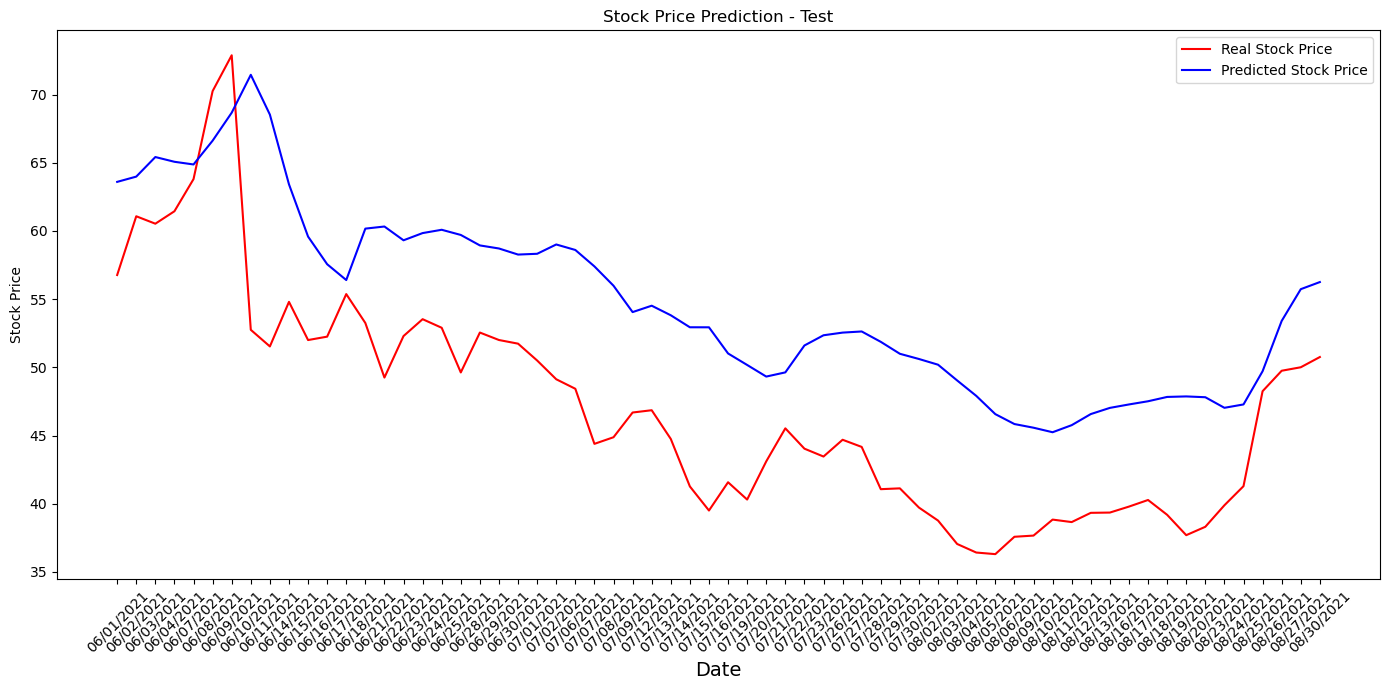

<Figure size 640x480 with 0 Axes>

In [1094]:
import matplotlib.ticker as ticker
#get the dates for plotting
test_date = test_sa['Date']
#real close price
real_stock_price = test_set.iloc[timesteps:lenOfReal+1,3:4].values 
# Setting the plot size for better readability
plt.figure(figsize=(14, 7))
#date is offset by timestep since we are predicting from the 21st day(since timestep is 20)
plt.plot(test_date[timesteps:],real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_date[timesteps:],predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction - Test')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price')
# Rotating date labels for better visibility
plt.xticks(rotation=45)
# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Ensure all labels and titles fit within the figure bounds
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('pic1.png')

##### Plot Training Results

In [1095]:
real_stock_price_train = pd.read_csv(traindata)
#real close price
real_stock_price_train = real_stock_price_train.iloc[timesteps:len(real_stock_price_train)+1,3:4].values


predicted_stock_price_train = regressor.predict(X_train)
#padding so that predicted_stock_price_train array has the same number of columns as the input data when scaling 
predicted_stock_price_train = np.pad(predicted_stock_price_train,((0,0),(0,dataNum-1)),'constant')
predicted_stock_price_train = sc.inverse_transform(predicted_stock_price_train)
#remove the padded columns from the predicted_stock_price_train array, leaving only the first column, 
#which contains the actual predictions for the closing stock price
predicted_stock_price_train = np.delete(predicted_stock_price_train, [1, 2, 3, 4, 5, 6, 7], axis=1)

#np.savetxt(stockID + '.csv', predicted_stock_price, fmt="%.3f", delimiter=",")

4/4 [==============================] - 1s 0s/step


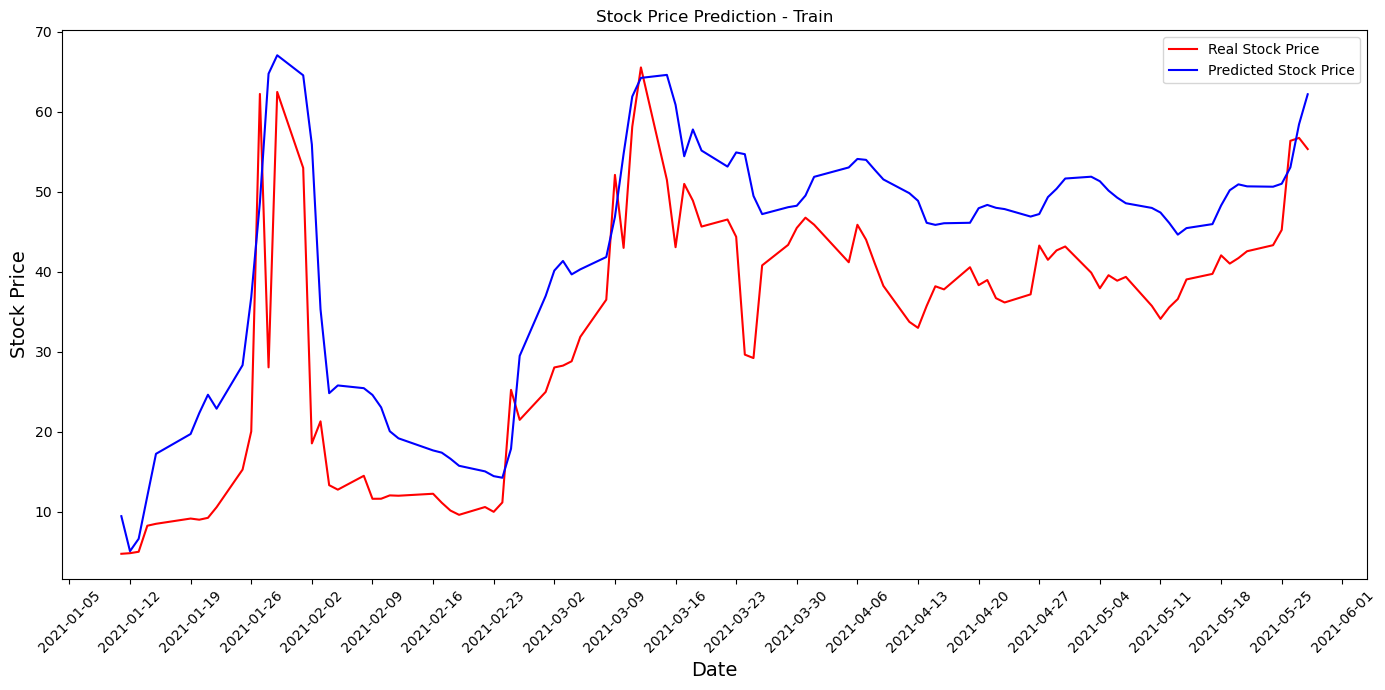

In [1096]:
import matplotlib.pyplot as plt

#get date field for plotting
train_date = pd.to_datetime(train_sa['Date'])
# Setting the plot size for better readability
plt.figure(figsize=(14, 7))
#date is offset by timestep since we are predicting from the 21st day(since timestep is 20)
plt.plot(train_date[timesteps:],real_stock_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(train_date[timesteps:],predicted_stock_price_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction - Train')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
# Rotating date labels for better visibility
plt.xticks(rotation=45)
# Adding a legend to distinguish between actual and predicted values
plt.legend()

 # Get the current axis
ax = plt.gca() 
# Set the locator to WeekdayLocator for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
# Set the formatter to show the year, month, and day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

# Ensure all labels and titles fit within the figure bounds
plt.tight_layout()

# Display the plot
plt.show()

##### Evaluate Model Performance

In [1097]:
import math
from sklearn.metrics import mean_squared_error

rmseTest = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("RMSE_test = " + str(rmseTest))
rmseTrain = math.sqrt(mean_squared_error(real_stock_price_train, predicted_stock_price_train))
print("RMSE_train = " + str(rmseTrain))

RMSE_test = 8.62729889973962
RMSE_train = 11.259580093474085
